# Subject-Wise vs. Record-Wise Cross Validation
**contact:** drew.wilimitis@vumc.org

## Import Libraries

In [1]:
# import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# set matplotlib style and plotting configuration
plt.style.use('seaborn')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

# # load models for plotting and try new plotting format
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

## Load Data

In [2]:
# load processed input data
data = pd.read_csv('../data/MIMIC3_FULL_PROCESSED_DATASET_20221022.csv')
data.head()
data.shape
data.SUBJECT_ID.nunique()
data.HADM_ID.nunique()
data.ICUSTAY_ID.nunique()
print(list(data.columns))
data.isna().sum().sort_values(ascending=False)
data.dtypes

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ADMITTIME,DISCHTIME,ETHNICITY,GENDER,AGE,LOS_STAY_LABEL,MORTALITY_STAY_LABEL,...,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS,GENDER_MALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN
0,50447,127105,253123,2164-06-17 03:06:00,2164-06-24 13:00:00,WHITE,F,53.719370,1.4437,0,...,0,0,0,0,0,1,0,0,0,0
1,78238,195560,224253,2150-09-29 21:20:00,2150-10-01 14:00:00,WHITE,F,77.275838,0.8005,0,...,0,0,0,0,0,1,0,0,0,0
2,78238,148934,259839,2150-10-23 10:43:00,2150-10-28 12:34:00,WHITE,F,77.341547,2.4825,0,...,0,0,0,0,0,1,0,0,0,0
3,13966,166620,231548,2187-10-07 20:04:00,2187-10-10 14:44:00,WHITE,M,74.349076,0.9708,0,...,0,0,0,0,1,1,0,0,0,0
4,351,174800,281750,2171-07-16 23:13:00,2171-07-25 19:36:00,BLACK/AFRICAN AMERICAN,F,51.071869,3.8597,0,...,0,0,0,0,0,0,0,1,0,0


(41121, 70)

33281

41121

41121

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITTIME', 'DISCHTIME', 'ETHNICITY', 'GENDER', 'AGE', 'LOS_STAY_LABEL', 'MORTALITY_STAY_LABEL', 'MORTALITY_INHOSPITAL_STAY_LABEL', 'ETHNICITY_NUM', 'GENDER_NUM', 'HEIGHT', 'WEIGHT', 'LOS_EPISODE_LABEL', 'MORTALITY_EPISODE_LABEL', 'HOURS', 'CAPILLARY REFILL RATE', 'DIASTOLIC BLOOD PRESSURE', 'FRACTION INSPIRED OXYGEN', 'GLASCOW COMA SCALE TOTAL', 'GLUCOSE', 'HEART RATE', 'HEIGHT.1', 'MEAN BLOOD PRESSURE', 'OXYGEN SATURATION', 'RESPIRATORY RATE', 'SYSTOLIC BLOOD PRESSURE', 'TEMPERATURE', 'WEIGHT.1', 'PH', 'SEPTICEMIA (EXCEPT IN LABOR)', 'DIABETES MELLITUS WITHOUT COMPLICATION', 'DIABETES MELLITUS WITH COMPLICATIONS', 'DISORDERS OF LIPID METABOLISM', 'FLUID AND ELECTROLYTE DISORDERS', 'ESSENTIAL HYPERTENSION', 'HYPERTENSION WITH COMPLICATIONS AND SECONDARY HYPERTENSION', 'ACUTE MYOCARDIAL INFARCTION', 'CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE', 'CONDUCTION DISORDERS', 'CARDIAC DYSRHYTHMIAS', 'CONGESTIVE HEART FAILURE; NONHYPERTENSIVE', 'AC

CAPILLARY REFILL RATE                                         40475
HEIGHT                                                        31792
HEIGHT.1                                                      31784
FRACTION INSPIRED OXYGEN                                      30697
GLASCOW COMA SCALE TOTAL                                      18524
                                                              ...  
ESSENTIAL HYPERTENSION                                            0
HYPERTENSION WITH COMPLICATIONS AND SECONDARY HYPERTENSION        0
ACUTE MYOCARDIAL INFARCTION                                       0
CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE                  0
RACE_OTHER_UNKNOWN                                                0
Length: 70, dtype: int64

SUBJECT_ID             int64
HADM_ID                int64
ICUSTAY_ID             int64
ADMITTIME             object
DISCHTIME             object
                       ...  
RACE_WHITE             int64
RACE_HISPANIC          int64
RACE_BLACK             int64
RACE_ASIAN             int64
RACE_OTHER_UNKNOWN     int64
Length: 70, dtype: object

In [3]:
# run cv experiements with selected features for mortality prediction
race_cols = [x for x in data.columns if 'RACE' in x]
data['GENDER_FEMALE'] = data.GENDER.apply(lambda x: 1 if x=='F' else 0)
dem_cols = ['GENDER_MALE', 'GENDER_FEMALE', 'AGE'] + race_cols
drop_cols = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITTIME', 'DISCHTIME', 'ETHNICITY', 'GENDER']
label_cols = [x for x in data.columns if 'LABEL' in x]
print(race_cols)
print(dem_cols)
print(label_cols)

# keep subject IDs for subject-wise cv
drop_cols.remove('SUBJECT_ID')
X = data.drop(drop_cols + label_cols, axis=1)
X.shape
y = data['MORTALITY_INHOSPITAL_STAY_LABEL']
y.shape
np.any(X.isna())
np.mean(y)
y.value_counts()

['RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK', 'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
['GENDER_MALE', 'GENDER_FEMALE', 'AGE', 'RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK', 'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
['LOS_STAY_LABEL', 'MORTALITY_STAY_LABEL', 'MORTALITY_INHOSPITAL_STAY_LABEL', 'LOS_EPISODE_LABEL', 'MORTALITY_EPISODE_LABEL']


(41121, 60)

(41121,)

True

0.10505581089954039

0    36801
1     4320
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

In [4]:
# defining column types for pre-processing
binary_dem_cols = ['GENDER_MALE', 'GENDER_FEMALE', 'RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK',
                   'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
binary_diag_cols = ['Septicemia (except in labor)', 'Diabetes mellitus without complication',
                    'Diabetes mellitus with complications', 'Disorders of lipid metabolism',
                    'Fluid and electrolyte disorders', 'Essential hypertension',
                    'Hypertension with complications and secondary hypertension', 'Acute myocardial infarction',
                    'Coronary atherosclerosis and other heart disease', 'Conduction disorders', 'Cardiac dysrhythmias',
                    'Congestive heart failure; nonhypertensive', 'Acute cerebrovascular disease',
                    'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
                    'Chronic obstructive pulmonary disease and bronchiectasis', 'Pleurisy; pneumothorax; pulmonary collapse',
                    'Respiratory failure; insufficiency; arrest (adult)', 'Other lower respiratory disease',
                    'Other upper respiratory disease', 'Other liver diseases', 'Gastrointestinal hemorrhage',
                    'Acute and unspecified renal failure', 'Chronic kidney disease',
                    'Complications of surgical procedures or medical care', 'Shock']
binary_admit_cols = ['ADMIT_DIAG_CARDIAC_ARREST', 'ADMIT_DIAG_BRAIN_HEMORRHAGE', 'ADMIT_DIAG_LIVER FAILURE',
                     'ADMIT_DIAG_CEREBROVASCULAR ACCIDENT', 'ADMIT_DIAG_SEPSIS', 'ADMIT_DIAG_HYPOXIA',
                     'ADMIT_DIAG_RESPIRATORY DISTRESS']
dem_cont_cols = ['AGE', 'HEIGHT', 'WEIGHT']
meas_cont_cols = ['Capillary refill rate', 'Diastolic blood pressure',
                  'Fraction inspired oxygen', 'Glascow coma scale total', 'Glucose', 'Heart Rate',
                  'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
                  'Systolic blood pressure', 'Temperature', 'pH']

# rename sets of feature columns
X.columns = [x.upper() for x in X.columns if x not in meas_cont_cols]
binary_dem_cols = [x.upper() for x in binary_dem_cols]
binary_diag_cols = [x.upper() for x in binary_diag_cols]
binary_admit_cols = [x.upper() for x in binary_admit_cols]
dem_cont_cols = [x.upper() for x in dem_cont_cols]

# set outlier age/weight/height values to NA for imputation
X.loc[(X.AGE > 110), 'AGE'] = np.nan
X.loc[(X.WEIGHT == 0), 'WEIGHT'] = np.nan
X.loc[(X.HEIGHT==0), 'HEIGHT'] = np.nan
cont_cols = dem_cont_cols
binary_cols = binary_dem_cols + binary_diag_cols + binary_admit_cols
features = cont_cols + binary_cols

In [5]:
import scipy.stats as st
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier, Perceptron
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, TimeSeriesSplit
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, mutual_info_classif, RFE, SelectFromModel
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, label_ranking_loss, zero_one_loss
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

# Load the dataset defined above
X_exp1 = X[['SUBJECT_ID'] + features].copy()
X_subjects = X_exp1['SUBJECT_ID']
y_exp1 = y.copy()

In [6]:
# examine correlations between records of patients
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, TimeSeriesSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression

# examine functioning of GroupKFold in scikit-learn 
subject_wise_cv = GroupKFold(n_splits=5)
groups = X_subjects.values

subject_wise_cv.get_n_splits(X_exp1, y_exp1, groups=groups)
for train_index, test_index in subject_wise_cv.split(X_exp1, y_exp1, groups):
    print("TRAIN:", train_index[:5], "TEST:", test_index[:5])
    X_train, X_test = X_exp1.iloc[train_index, :], X_exp1.iloc[test_index, :]
    y_train, y_test = y_exp1.iloc[train_index], y_exp1.iloc[test_index]
    print(len(np.unique(X_train.SUBJECT_ID)), X_test.shape)
    print(len(np.unique(X_test.SUBJECT_ID)), X_train.shape)

5

TRAIN: [0 3 4 5 6] TEST: [ 1  2  7  8 11]
26625 (8225, 43)
6656 (32896, 43)
TRAIN: [0 1 2 3 4] TEST: [ 5 10 13 14 24]
26625 (8224, 43)
6656 (32897, 43)
TRAIN: [0 1 2 5 6] TEST: [ 3  4 18 19 25]
26625 (8224, 43)
6656 (32897, 43)
TRAIN: [0 1 2 3 4] TEST: [ 6 23 31 33 40]
26625 (8224, 43)
6656 (32897, 43)
TRAIN: [1 2 3 4 5] TEST: [ 0  9 20 30 35]
26624 (8224, 43)
6657 (32897, 43)


In [7]:
# assign subject IDs to test/train folds and make sure there's no overlap
data.SUBJECT_ID.nunique()
test_ids = {}
train_ids = {}
i = 1
for train_index, test_index in subject_wise_cv.split(X_exp1, y_exp1, groups):
    X_train, X_test = X_exp1.iloc[train_index, :], X_exp1.iloc[test_index, :]
    y_train, y_test = y_exp1.iloc[train_index], y_exp1.iloc[test_index]
    len(np.unique(X_train.SUBJECT_ID.values))
    len(np.unique(X_test.SUBJECT_ID.values))
    test_ids['fold_' + str(i)] = np.unique(X_test.SUBJECT_ID.values)
    train_ids['fold_' + str(i)] = np.unique(X_train.SUBJECT_ID.values)
    i+=1

33281

26625

6656

26625

6656

26625

6656

26625

6656

26624

6657

In [8]:
# here we see every subject ID (and their visits) are only within same test fold
test_group_dfs = []
for k,v in test_ids.items():
    fold_nums = np.repeat(k, len(v))
    subject_ids = v
    test_group_df = pd.DataFrame(np.array([subject_ids, fold_nums]).T)
    test_group_dfs.append(test_group_df)
subject_test_folds = pd.concat(test_group_dfs).reset_index(drop=True)
subject_test_folds.columns = ['SUBJECT_ID', 'CV_Test_Fold']
subject_test_folds.groupby('SUBJECT_ID')['CV_Test_Fold'].nunique().agg([np.min, np.max])
subject_test_folds

# all other subject IDs are within the other training folds
train_group_dfs = []
for k,v in train_ids.items():
    fold_nums = np.repeat(k, len(v))
    subject_ids = v
    train_group_df = pd.DataFrame(np.array([subject_ids, fold_nums]).T)
    train_group_dfs.append(train_group_df)
subject_train_folds = pd.concat(train_group_dfs).reset_index(drop=True)
subject_train_folds.columns = ['SUBJECT_ID', 'CV_Train_Fold']
subject_train_folds.groupby('SUBJECT_ID')['CV_Train_Fold'].nunique().agg([np.min, np.max])
subject_train_folds

amin    1
amax    1
Name: CV_Test_Fold, dtype: int64

,SUBJECT_ID,CV_Test_Fold
0,3,fold_1
1,6,fold_1
2,19,fold_1
3,26,fold_1
4,33,fold_1
...,...,...
33276,99897,fold_5
33277,99913,fold_5
33278,99938,fold_5
33279,99955,fold_5


amin    4
amax    4
Name: CV_Train_Fold, dtype: int64

,SUBJECT_ID,CV_Train_Fold
0,4,fold_1
1,9,fold_1
2,11,fold_1
3,12,fold_1
4,17,fold_1
...,...,...
133119,99985,fold_5
133120,99991,fold_5
133121,99992,fold_5
133122,99995,fold_5


In [9]:
# define function to apply non-nested CV experiments with optional parameters
def apply_cross_validation(X, y, model='LogisticRegression', n_folds=5, n_repeats=10,
                           verbose=True, groups=None):
    # define methods to use for cross validation
    subject_wise_kf = GroupKFold(n_splits=5)
    cv_methods = [subject_wise_kf]
    cv_names = ['GroupKFoldCV']
    cv_types = dict(zip(cv_names, cv_methods))
    
    # define column transformers based on given feature subsets
    ss_cols = cont_cols # to use with standard scaler

    # combine transformers with Column Transformer
    ss = StandardScaler()

    overall_transformer = ColumnTransformer(
        transformers=[
            ("standard_scaler", ss, ss_cols),
        ]
    )

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    feature_selector = SelectKBest(mutual_info_classif)

    # specify classifier to use
    if model == 'LogisticRegression':
        clf = LogisticRegression(solver='saga', n_jobs=-1)
    elif model == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    else:
        print('Must specify one of the allowed classifiers')
        pass

    # pipeline requires ordered input for preprocessing
    pipe = Pipeline(steps=[('imputer', imputer),
                           ('preprocessor', ss),
                           ('select', feature_selector),
                           ('classify', clf)])

    # double underscore allows access to pipeline step
    pipe_params = {'classify__C': np.power(10., np.arange(-2,2)),
                   'classify__penalty': ['l1', 'l2', 'none'],
                   'select__k': [15, 30]}
    
    # initalize objects to hold cv results
    cv_dict = {}
    cv_dfs = []
    cv_run_times = []
    cv_types = dict(zip(cv_names, cv_methods))
    
    # iterate over each CV method and apply grid search
    for name, split_fn in cv_types.items():
        print(name)
        start_time = time()
        gs = GridSearchCV(pipe, pipe_params, cv=split_fn, verbose=True, n_jobs=-1,
                          scoring=['average_precision', 'roc_auc'],
                          return_train_score=False, refit="average_precision")
        gs.fit(X, y, groups=groups)
        cv = gs.cv_results_
        total_time = time() - start_time
        cv['total_runtime'] = total_time
        cv_run_times.append(total_time)
        df = pd.DataFrame(cv)
        df['method'] = name
        cv_dfs.append(df)
        cv['gs_best_score_'] = gs.best_score_
        cv['gs_best_estimator_'] = gs.best_estimator_
        cv_dict[name] = cv
    return cv_dict

In [10]:
# function for comparing CV and validation set metrics
def compare_cv_validation_metrics(cv_dict, X_val, y_val):
    val_dict = {}
    val_auprs = []
    val_aurocs = []
    for cv_method in list(cv_dict.keys()):
        run_time = cv_dict[cv_method]['total_runtime']
        cv_auprs = cv_dict[cv_method]['best_auprs']
        cv_aurocs = cv_dict[cv_method]['best_aurocs']
        best_mean_aupr = np.mean(cv_auprs)
        best_mean_auroc = np.mean(cv_aurocs)
        best_aupr = np.max(cv_auprs)
        best_auroc = np.max(cv_aurocs)
        best_clf = cv_dict[cv_method]['best_estimator']

        # predict on validation set using best model from CV
        y_pred = best_clf.predict_proba(X_val)[:, 1]
        val_aupr = average_precision_score(y_true = y_val, y_score=y_pred)
        val_auroc = roc_auc_score(y_true = y_val, y_score=y_pred)
        val_auprs.append(val_aupr)
        val_aurocs.append(val_auroc)

        # get metrics and save as dict
        val_dict[cv_method] = {}
        val_dict[cv_method]['Runtime'] = run_time
        val_dict[cv_method]['CV_Best_Avg_AUPR'] = best_mean_aupr
        val_dict[cv_method]['CV_Best_Avg_AUROC'] = best_mean_auroc
        val_dict[cv_method]['CV_Best_AUPR'] = best_aupr
        val_dict[cv_method]['CV_Best_AUROC'] = best_auroc
        val_dict[cv_method]['Val_AUPR'] = val_aupr
        val_dict[cv_method]['Val_AUROC'] = val_auroc
        val_dict[cv_method]['Val_Relative_Best_CV_AUPR'] =  val_aupr / best_aupr
        val_dict[cv_method]['Val_Relative_Best_CV_AUROC'] = val_auroc / best_auroc
        val_dict[cv_method]['Val_Relative_Avg_CV_AUPR'] =  val_aupr / best_mean_aupr
        val_dict[cv_method]['Val_Relative_Avg_CV_AUROC'] = val_auroc / best_mean_auroc
    
    # return final metrics as dictionary
    return val_dict

In [115]:
# Load the dataset defined above
# X_exp1 = X[features].copy()
# y_exp1 = y.copy()

X_exp1 = X[['SUBJECT_ID'] + features].copy()
X_subjects = X_exp1['SUBJECT_ID']
y_exp1 = y.copy()

# split data into separate validation set (use to estimate true test error)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_exp1, y_exp1, random_state=8888,
                                                  shuffle=True, stratify=y_exp1,
                                                  test_size=0.2)

# examine training dataset (to use with CV) and validation dataset
print('Examining inner train set to use with CV')
X_train.head()
X_train.shape
y_train.head()
y_train.shape
y_train.mean()

print('Examining held-out validation set for CV test error')
X_val.head()
X_val.shape
y_val.head()
y_val.shape
y_val.mean()

Examining inner train set to use with CV


,SUBJECT_ID,AGE,HEIGHT,WEIGHT,GENDER_MALE,GENDER_FEMALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,...,CHRONIC KIDNEY DISEASE,COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL CARE,SHOCK,ADMIT_DIAG_CARDIAC_ARREST,ADMIT_DIAG_BRAIN_HEMORRHAGE,ADMIT_DIAG_LIVER FAILURE,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS
4272,73075,54.212183,175.0,105.777654,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9444,43970,71.865845,NaN,106.775557,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19882,9863,59.129363,NaN,155.000000,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
40384,80675,84.665298,178.0,83.460928,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15487,4407,82.083504,NaN,87.599998,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(32896, 43)

4272     0
9444     0
19882    0
40384    0
15487    0
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

(32896,)

0.10505836575875487

Examining held-out validation set for CV test error


,SUBJECT_ID,AGE,HEIGHT,WEIGHT,GENDER_MALE,GENDER_FEMALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,...,CHRONIC KIDNEY DISEASE,COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL CARE,SHOCK,ADMIT_DIAG_CARDIAC_ARREST,ADMIT_DIAG_BRAIN_HEMORRHAGE,ADMIT_DIAG_LIVER FAILURE,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS
39878,85083,NaN,163.0,68.356314,0,1,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
846,6231,43.047228,NaN,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14438,13564,32.071184,NaN,NaN,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16189,69531,47.373032,NaN,74.200000,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
15304,94781,38.042437,163.0,167.647603,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


(8225, 43)

39878    0
846      0
14438    0
16189    0
15304    0
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

(8225,)

0.10504559270516717

In [119]:
# define methods to use for cross validation
subject_wise_kf = GroupKFold(n_splits=5)
cv_methods = [subject_wise_kf]
cv_names = ['GroupKFoldCV']
cv_types = dict(zip(cv_names, cv_methods))

# repeat non-nested CV & validation set comparison multiple times
print('Begin Subject-Wise CV & Validation Set Comparison\n')

NUM_TRIALS = 10
val_result_dfs = []
for i in range(NUM_TRIALS):
    print('Trial #: {}'.format(i+1))
    
    # get train/test sets to use for CV & validation set metrics (don't set same random seed)
    X_train, X_val, y_train, y_val = train_test_split(X_exp1, y_exp1,
                                                      shuffle=True,
                                                      stratify=y_exp1,
                                                      test_size=0.2)
    
    # run experiment applying all non-nested CV methods
    groups = X_train.SUBJECT_ID.values
    X_train = X_train.drop('SUBJECT_ID', axis=1)
    cv_dict = apply_cross_validation(X_train, y_train, n_folds=5,
                                     groups=groups)
    
    # store performance/runtime results
    auc_dict = {}
    for cv_method in cv_names:
        if 'Repeated' in cv_method:
            n_splits = 50
        else:
            n_splits = 5
        auc_dict[cv_method] = {}
        
        # get aupr/auroc scores from best grid search configuration model
        best_aupr_index = np.argmin(cv_dict[cv_method]['rank_test_average_precision'])
        best_auprs = []
        best_auroc_index = np.argmin(cv_dict[cv_method]['rank_test_roc_auc'])
        best_aurocs = []
        
        # store best results for each split
        for k in range(n_splits):
            aupr = cv_dict[cv_method]['split' + str(k) + '_test_average_precision'][best_aupr_index]
            best_auprs.append(aupr)
            auroc = cv_dict[cv_method]['split' + str(k) + '_test_roc_auc'][best_auroc_index]
            best_aurocs.append(auroc)
            
        # store overall results and pass to validation comparison function
        mean_aupr = np.mean(best_auprs)
        std_aupr = np.std(best_auprs)
        mean_auroc = np.mean(best_aurocs)
        std_auroc = np.std(best_aurocs)
        auc_dict[cv_method]['mean_aupr'] = round(mean_aupr, 3)
        auc_dict[cv_method]['std_aupr'] = round(std_aupr, 3)
        auc_dict[cv_method]['best_auprs'] = best_auprs
        auc_dict[cv_method]['mean_auroc'] = round(mean_auroc, 3)
        auc_dict[cv_method]['std_auroc'] = round(std_auroc, 3)
        auc_dict[cv_method]['best_aurocs'] = best_aurocs
        auc_dict[cv_method]['best_estimator'] = cv_dict[cv_method]['gs_best_estimator_']
        auc_dict[cv_method]['total_runtime'] = cv_dict[cv_method]['total_runtime']
    
    # compare cross-validation performance with initially held-out validation set
    X_val = X_val.drop('SUBJECT_ID', axis=1)
    val_metrics = compare_cv_validation_metrics(auc_dict, X_val, y_val)
    val_df = pd.DataFrame(val_metrics)
    val_df['trial_num'] = i + 1
    print('Trial {} Finished - Saving results to csv'.format(str(i+1)))
    val_df.to_csv('../plots/MORTALITY_PREDICTION_SUBJECT_WISE_CV_VALIDATION_REPEAT_TRIAL_' + str(i+1) + '_5_FOLDS_WITH_TUNING.csv', index=False)
    val_result_dfs.append(val_df)

Begin Subject-Wise CV & Validation Set Comparison

Trial #: 1
GroupKFoldCV
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Trial 1 Finished - Saving results to csv
Trial #: 2
GroupKFoldCV
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Trial 2 Finished - Saving results to csv
Trial #: 3
GroupKFoldCV
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Trial 3 Finished - Saving results to csv
Trial #: 4
GroupKFoldCV
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Trial 4 Finished - Saving results to csv
Trial #: 5
GroupKFoldCV
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Trial 5 Finished - Saving results to csv
Trial #: 6
GroupKFoldCV
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Trial 6 Finished - Saving results to csv
Trial #: 7
GroupKFoldCV
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Trial 7 Finished - Saving results to csv
Trial #: 8
GroupKFoldCV
Fitting 5 folds for each of 24 candi

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.

## Load optimism error data from subject-CV

In [15]:
# load and concatenate dataframes
non_nested_val_dfs = []
subject_cv_val_dfs = []
NUM_TRIALS = 10
for i in range(NUM_TRIALS):
    subject_cv_df = pd.read_csv('../plots/MORTALITY_PREDICTION_SUBJECT_WISE_CV_VALIDATION_REPEAT_TRIAL_' + str(i+1) + '_5_FOLDS_WITH_TUNING.csv')
    non_nested_val_df = pd.read_csv('../plots/MORTALITY_PREDICTION_CV_VALIDATION_REPEAT_TRIAL_' + str(i+1) + '_5_FOLDS_WITH_TUNING.csv')
    subject_cv_val_dfs.append(subject_cv_df)
    non_nested_val_dfs.append(non_nested_val_df)

In [32]:
subject_cv_val_df = pd.concat(subject_cv_val_dfs)
non_nested_val_df = pd.concat(non_nested_val_dfs)
combined_cv_val_df = pd.read_csv('../plots/Mortality/MORTALITY_PREDICTION_REPEATED_5_FOLD_VALIDATION_VS_CV_ERROR_METRICS.csv')
combined_cv_val_df

nested_val_df = pd.read_csv('../plots/MORTALITY_PREDICTION_NESTED_CV_VALIDATION_REPEATED_5_FOLDS_WITH_TUNING_TEST.csv')
subject_cv_val_df['Metric'] = np.tile(nested_val_df['Unnamed: 0'], 10)
subject_cv_val_df

,Unnamed: 0,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num,NestedCV
0,0,CV_Best_AUPR,0.415253,0.416289,0.440490,0.440472,1,0.437024
1,1,CV_Best_AUROC,0.844158,0.850789,0.854280,0.858097,1,0.847011
2,2,CV_Best_Avg_AUPR,0.407855,0.409129,0.407333,0.407468,1,0.408902
3,3,CV_Best_Avg_AUROC,0.838813,0.838201,0.837950,0.837688,1,0.837326
4,4,Runtime,84.900918,82.737554,717.042853,715.740019,1,315.822449
...,...,...,...,...,...,...,...,...
105,105,Val_AUROC,0.835981,0.833347,0.836770,0.837702,10,0.837823
106,106,Val_Relative_Avg_CV_AUPR,1.002049,0.975730,0.996489,0.999716,10,0.993946
107,107,Val_Relative_Avg_CV_AUROC,0.996711,0.993232,0.998956,1.000050,10,1.001084
108,108,Val_Relative_Best_CV_AUPR,0.962241,0.946453,0.915637,0.914498,10,0.958729


,GroupKFoldCV,trial_num,Metric
0,0.433226,1,CV_Best_AUPR
1,0.846919,1,CV_Best_AUROC
2,0.406007,1,CV_Best_Avg_AUPR
3,0.838414,1,CV_Best_Avg_AUROC
4,82.907953,1,Runtime
...,...,...,...
6,0.843202,10,Val_AUROC
7,1.039401,10,Val_Relative_Avg_CV_AUPR
8,1.008437,10,Val_Relative_Avg_CV_AUROC
9,0.991569,10,Val_Relative_Best_CV_AUPR


In [34]:
# # combine sorted dataframes to align results for nested and non-nested
cv_val_results = combined_cv_val_df.sort_values(by=['trial_num', 'Metric']).merge(subject_cv_val_df.sort_values(by=['trial_num', 'Metric']), on=['trial_num', 'Metric'])
cv_val_results

,Unnamed: 0,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,trial_num,NestedCV,GroupKFoldCV
0,0,CV_Best_AUPR,0.415253,0.416289,0.440490,0.440472,1,0.437024,0.433226
1,1,CV_Best_AUROC,0.844158,0.850789,0.854280,0.858097,1,0.847011,0.846919
2,2,CV_Best_Avg_AUPR,0.407855,0.409129,0.407333,0.407468,1,0.408902,0.406007
3,3,CV_Best_Avg_AUROC,0.838813,0.838201,0.837950,0.837688,1,0.837326,0.838414
4,4,Runtime,84.900918,82.737554,717.042853,715.740019,1,315.822449,82.907953
...,...,...,...,...,...,...,...,...,...
105,105,Val_AUROC,0.835981,0.833347,0.836770,0.837702,10,0.837823,0.843202
106,106,Val_Relative_Avg_CV_AUPR,1.002049,0.975730,0.996489,0.999716,10,0.993946,1.039401
107,107,Val_Relative_Avg_CV_AUROC,0.996711,0.993232,0.998956,1.000050,10,1.001084,1.008437
108,108,Val_Relative_Best_CV_AUPR,0.962241,0.946453,0.915637,0.914498,10,0.958729,0.991569


In [46]:
cv_val_results.groupby('Metric')['KFoldCV'].agg([np.mean, np.median, np.std]).reset_index().iloc[7:11]
cv_val_results.groupby('Metric')['GroupKFoldCV'].agg([np.mean, np.median, np.std]).reset_index().iloc[7:11]

,Metric,mean,median,std
7,Val_Relative_Avg_CV_AUPR,1.007005,1.001425,0.033794
8,Val_Relative_Avg_CV_AUROC,1.000770,0.998173,0.008434
9,Val_Relative_Best_CV_AUPR,0.962941,0.953923,0.034751
10,Val_Relative_Best_CV_AUROC,0.990628,0.989631,0.008155


,Metric,mean,median,std
7,Val_Relative_Avg_CV_AUPR,1.013242,1.019689,0.026636
8,Val_Relative_Avg_CV_AUROC,1.004633,1.005076,0.007654
9,Val_Relative_Best_CV_AUPR,0.958419,0.958846,0.028270
10,Val_Relative_Best_CV_AUROC,0.994225,0.994650,0.008862


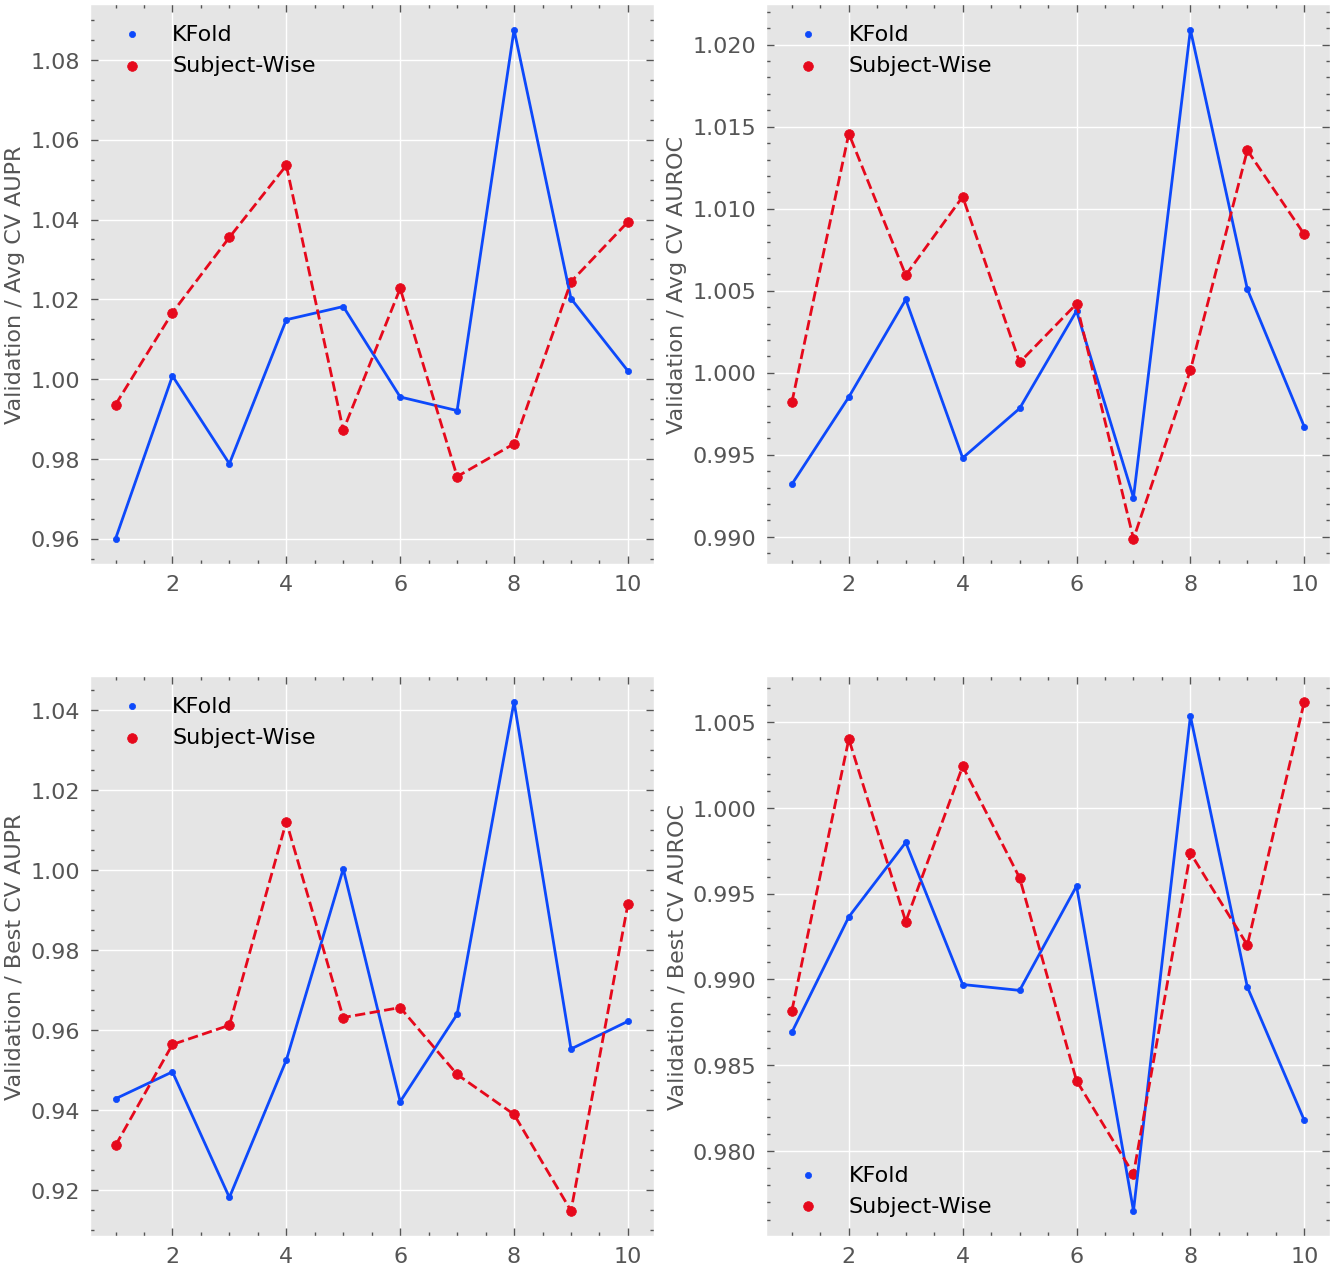

In [62]:
plt.figure(figsize=(16,16))
plt.style.reload_library()
plt.style.use('default')
plt.style.use('seaborn-notebook')
plt.style.use('ggplot')
plt.style.use(['science', 'notebook', 'vibrant', 'high-vis'])

plt.subplot(221)
plt.plot(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Avg_CV_AUPR']['KFoldCV'])
plt.scatter(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Avg_CV_AUPR']['KFoldCV'],
            s=20, label='KFold')

plt.plot(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Avg_CV_AUPR']['GroupKFoldCV'])
plt.scatter(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Avg_CV_AUPR']['GroupKFoldCV'],
            label='Subject-Wise')
plt.ylabel('Validation / Avg CV AUPR')
plt.legend()

plt.subplot(222)
plt.plot(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Avg_CV_AUROC']['KFoldCV'])
plt.scatter(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Avg_CV_AUROC']['KFoldCV'],
            s=20, label='KFold')

plt.plot(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Avg_CV_AUROC']['GroupKFoldCV'])
plt.scatter(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Avg_CV_AUROC']['GroupKFoldCV'],
            label='Subject-Wise')
plt.legend()
plt.ylabel('Validation / Avg CV AUROC')

plt.subplot(223)
plt.plot(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Best_CV_AUPR']['KFoldCV'])
plt.scatter(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Best_CV_AUPR']['KFoldCV'],
            s=20, label='KFold')

plt.plot(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Best_CV_AUPR']['GroupKFoldCV'])
plt.scatter(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Best_CV_AUPR']['GroupKFoldCV'],
            label='Subject-Wise')
plt.legend()
plt.ylabel('Validation / Best CV AUPR')

plt.subplot(224)
plt.plot(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Best_CV_AUROC']['KFoldCV'])
plt.scatter(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Best_CV_AUROC']['KFoldCV'],
            s=20, label='KFold')

plt.plot(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Best_CV_AUROC']['GroupKFoldCV'])
plt.scatter(np.arange(1, 11, 1), cv_val_results[cv_val_results.Metric=='Val_Relative_Best_CV_AUROC']['GroupKFoldCV'],
            label='Subject-Wise')
plt.ylabel('Validation / Best CV AUROC')
plt.legend()
plt.savefig('../plots/Mortality/SUBJECT_WISE_CV_VALIDATION_AND_KFOLD_CV_LINEPLOTS_GRID.png', dpi=300)
plt.show();